In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.utils as image
from sklearn.preprocessing import OneHotEncoder
from keras.src.utils import to_categorical,normalize
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras.layers as layers
from keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
for dirname, _, filenames in os.walk("/kaggle/input/dataset-nn23"):
    Image_Count = 0
#     print(dirname)

    for file in filenames:
        Image_Count += 1

    if Image_Count > 0:
        print('Total Files in directory {} is {}'.format(dirname, Image_Count))

Total Files in directory /kaggle/input/dataset-nn23/dataset/test is 100
Total Files in directory /kaggle/input/dataset-nn23/dataset/train/2 is 1980
Total Files in directory /kaggle/input/dataset-nn23/dataset/train/5 is 1980
Total Files in directory /kaggle/input/dataset-nn23/dataset/train/3 is 1980
Total Files in directory /kaggle/input/dataset-nn23/dataset/train/1 is 1980
Total Files in directory /kaggle/input/dataset-nn23/dataset/train/4 is 1980


In [3]:
train_path = '/kaggle/input/dataset-nn23/dataset/train/'
test_path = '/kaggle/input/dataset-nn23/dataset/test/'

In [4]:
IMG_SIZE = 250
classes = ['1', '2', '3', '4', '5']
Input_Shape = (IMG_SIZE, IMG_SIZE, 3)
images = []
labels = []
for c in classes:
    for img in os.listdir(train_path + c):
        img = cv2.imread(train_path + c + '/' + img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(int(c))
        
images = np.array(images, dtype='float32')/255.0        

In [5]:
onehotencoder = OneHotEncoder()
label = np.array(labels).reshape(-1,1)
labels = onehotencoder.fit_transform(label).toarray()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(type(y_val))
print(type(X_val))

(7920, 250, 250, 3)
(7920, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [9]:
training_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
)

training_datagen.fit(X_train)
training_datagen.fit(X_val)

In [10]:
print(X_val.shape)
print(y_val.shape)

(1980, 250, 250, 3)
(1980, 5)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a Positional Encoding layer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.encoding = self.positional_encoding(max_len, embedding_dim)

    def positional_encoding(self, max_len, embedding_dim):
        position = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, embedding_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embedding_dim))
        pos_enc = position * div_term
        pos_enc = tf.stack([tf.sin(pos_enc), tf.cos(pos_enc)], axis=-1)
        pos_enc = tf.reshape(pos_enc, [max_len, 1, embedding_dim])
        return pos_enc

    def call(self, inputs):
        return inputs + self.encoding

# Create a Transformer Encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embedding_dim, num_heads=8, ff_dim=1024, dropout=0.1, name="transformer_encoder"):
        super(TransformerEncoder, self).__init__(name=name)

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(embedding_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Create a modified AlexNet with Transformer Encoder and Positional Encoding
def create_transformer_alexnet(input_shape, num_classes, embedding_dim=256, num_heads=8):
    # Define AlexNet architecture up to the transformer encoder layer
    base_model = models.Sequential([
        layers.Conv2D(96, 11, strides=(4, 4), padding='valid', input_shape=input_shape, activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
        layers.BatchNormalization(),
        layers.Conv2D(256, 5, strides=(1, 1), padding='valid', activation='relu'),
        layers.Conv2D(256, 5, strides=(1, 1), padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
        layers.BatchNormalization(),
        layers.Conv2D(384, 3, strides=(1, 1), padding='valid', activation='relu'),
        layers.Conv2D(384, 3, strides=(1, 1), padding='valid', activation='relu'),
        layers.Conv2D(256, 3, strides=(1, 1), padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
        layers.BatchNormalization(),
    ])

    # Extract features from AlexNet
    features = base_model.output
    
    # Add positional encoding layer
    max_len = tf.reduce_prod(features.shape[1:-1])
    pos_encoding = PositionalEncoding(max_len, embedding_dim)(features)

    # Add transformer encoder layer
    transformer_encoder = TransformerEncoder(embedding_dim, num_heads)(pos_encoding)

    # Flatten the output before applying Global Average Pooling
    flattened_transformer = layers.Flatten()(transformer_encoder)
    
    # Add dense layers for classification
    x = layers.Dense(256, activation='relu')(flattened_transformer)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = models.Model(inputs=base_model.input, outputs=x)
    
    return model

# Example usage:
input_shape = (250, 250, 3)
num_classes = 5  # adjust based on your task
model = create_transformer_alexnet(input_shape, num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 29, 29, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 256)       614656    
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       163865

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

In [17]:
history=model.fit(training_datagen.flow(X_train, y_train, batch_size=64),
         validation_data=training_datagen.flow(X_val, y_val),epochs=100,steps_per_epoch=130, callbacks=callbacks)

Epoch 1/100


2023-12-19 14:31:08.313447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/transformer_encoder/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


130/130 [==============================] - 173s 1s/step - loss: 1.3747 - accuracy: 0.4129 - val_loss: 1.7857 - val_accuracy: 0.3162
Epoch 2/100
130/130 [==============================] - 157s 1s/step - loss: 1.2337 - accuracy: 0.4763 - val_loss: 1.2456 - val_accuracy: 0.4712
Epoch 3/100
130/130 [==============================] - 156s 1s/step - loss: 1.1695 - accuracy: 0.5141 - val_loss: 1.6753 - val_accuracy: 0.3434
Epoch 4/100
130/130 [==============================] - 157s 1s/step - loss: 1.1489 - accuracy: 0.5400 - val_loss: 1.1435 - val_accuracy: 0.5328
Epoch 5/100
130/130 [==============================] - 157s 1s/step - loss: 1.1295 - accuracy: 0.5423 - val_loss: 1.4020 - val_accuracy: 0.3939
Epoch 6/100
130/130 [==============================] - 157s 1s/step - loss: 1.1194 - accuracy: 0.5463 - val_loss: 1.2794 - val_accuracy: 0.4616
Epoch 7/100
130/130 [==============================] - 156s 1s/step - loss: 1.0879 - accuracy: 0.5756 - val_loss: 1.0543 - val_accuracy: 0.5525
Epoc

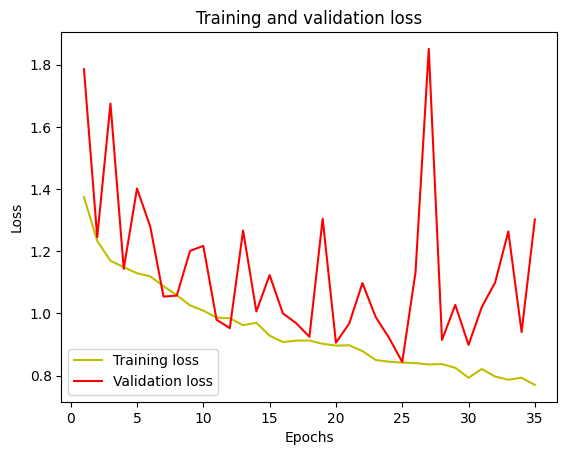

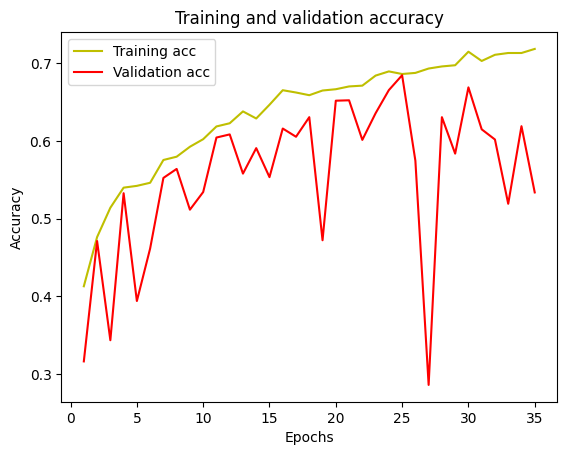

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
score = model.evaluate(X_val, y_val, verbose = 0 )
print("Test Loss: ", score[0])
print("Test accuracy: ", score[1])

Test Loss:  0.8032241463661194
Test accuracy:  0.7040404081344604


In [20]:
X_test = []
image_coulmn=[]
for img in os.listdir(test_path):
    image_coulmn.append(int((img.split('.'))[0]))
    img = cv2.imread(test_path + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Preprocess the image if needed (e.g., resizing, normalization)
    img = cv2.resize(img,(250, 250))  # Resize to match your target size
    X_test.append(img)

# Convert the list of images to a NumPy array
X_test = np.array(X_test)/255.0

In [21]:
Output=model.predict(X_test, batch_size=64, verbose=0)

In [22]:
Prediction_classes=[]
for predict in Output:
    index=np.argmax(predict)
    Prediction_classes.append(index+1)

In [23]:
Prediction_classes

[3,
 4,
 1,
 2,
 1,
 2,
 5,
 5,
 4,
 4,
 3,
 2,
 1,
 5,
 2,
 3,
 4,
 3,
 3,
 1,
 4,
 1,
 5,
 2,
 2,
 1,
 1,
 5,
 2,
 2,
 5,
 5,
 1,
 3,
 4,
 3,
 5,
 1,
 2,
 4,
 1,
 1,
 2,
 3,
 5,
 1,
 2,
 5,
 4,
 4,
 2,
 1,
 5,
 2,
 4,
 1,
 5,
 1,
 1,
 5,
 2,
 2,
 1,
 5,
 2,
 3,
 2,
 2,
 5,
 1,
 3,
 3,
 5,
 1,
 3,
 1,
 2,
 2,
 5,
 2,
 1,
 5,
 2,
 5,
 5,
 1,
 4,
 4,
 3,
 3,
 1,
 3,
 2,
 2,
 4,
 2,
 1,
 2,
 3,
 3]

In [24]:
# Create a dictionary with two columns
data = {'image_id': image_coulmn,'label': Prediction_classes}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

df.to_csv('file2.csv', index=False)